Relevant Feature Extraction with SHAP
===

Avicenna uses a pattern matching approach to learn and relations between input elements. Matching all input elements (features) and assosiating their relation with the program behavior is not feasible. Thus, **Avicenna** uses a machine learning model to differentiate between passing and failing inputs (based on the input properties) and then uses [SHAP]() to extract the input elements that have the highest influence on the prediction outcome.

In the following notebook, we will demonstrate how **Avicenna** extracts the most important input elements that are most likely to cause the failure.

#### Example Subject

We use our sample calculator subject to illustrate Avicenna's capabilities. Please refere to the other notebooks, like [calculator.ipynb](./calculator.ipynb), for an in-depth walkthrough of the calculator subject.

In [1]:
from avicenna_formalizations.calculator import grammar, oracle, initial_inputs

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
for inp in initial_inputs:
    print(inp.ljust(20), oracle(inp))

cos(10)              NO_BUG
sqrt(28367)          NO_BUG
tan(-12)             NO_BUG
sqrt(-900)           BUG


In [3]:
from fuzzingbook.Parser import EarleyParser, tree_to_string

parser = EarleyParser(grammar)
for inp in initial_inputs:
    for tree in parser.parse(inp):
        assert tree_to_string(tree) == inp

## Constructing Feature Vectors

In [4]:
from avicenna.oracle import OracleResult
from avicenna.input import Input
from avicenna.monads import Exceptional
from avicenna.feature_collector import GrammarFeatureCollector

In [5]:
test_inputs = set()
for inp in initial_inputs:
    test_inputs.add(
        Input.from_str(grammar, inp, oracle=oracle(inp))
    )

for inp in test_inputs:
    print(str(type(inp)).ljust(40), str(inp).ljust(20), inp.oracle)

<class 'avicenna.input.Input'>           cos(10)              NO_BUG
<class 'avicenna.input.Input'>           sqrt(-900)           BUG
<class 'avicenna.input.Input'>           tan(-12)             NO_BUG
<class 'avicenna.input.Input'>           sqrt(28367)          NO_BUG


#### Collecting Features

In [6]:
from avicenna.feature_collector import GrammarFeatureCollector, FeatureVector
from avicenna.features import NumericFeature

collector = GrammarFeatureCollector(grammar, feature_types=[NumericFeature])

In [7]:
feature_vector: FeatureVector = collector.collect_features(
    Input.from_str(grammar, "sqrt(-900)")
)

In [8]:
print(feature_vector)

sqrt(-900): {num(<onenine>): 9.0, num(<digit>): 0.0, num(<maybe_frac>): -inf, num(<number>): -900.0, num(<maybe_digits>): 0.0, num(<digits>): 0.0}


In [9]:
from avicenna.features import (
    ExistenceFeature,
    NumericFeature,
    LengthFeature,
    DerivationFeature,
)

features = [
    ExistenceFeature,
    NumericFeature,
    DerivationFeature,
    LengthFeature
]
collector = GrammarFeatureCollector(grammar, feature_types=features)
feature_vector: FeatureVector = collector.collect_features(
    Input.from_str(grammar, "sqrt(-900)")
)
print(feature_vector)

sqrt(-900): {exists(<start>): 1, exists(<arith_expr>): 1, exists(<function>): 1, exists(<number>): 1, exists(<maybe_minus>): 1, exists(<onenine>): 1, exists(<digit>): 1, exists(<maybe_digits>): 1, exists(<digits>): 1, exists(<maybe_frac>): 1, num(<onenine>): 9.0, num(<digit>): 0.0, num(<maybe_frac>): -inf, num(<number>): -900.0, num(<maybe_digits>): 0.0, num(<digits>): 0.0, exists(<start> -> <arith_expr>): 1, exists(<arith_expr> -> <function>(<number>)): 1, exists(<function> -> sqrt): 1, exists(<function> -> sin): 0, exists(<function> -> cos): 0, exists(<function> -> tan): 0, exists(<number> -> <maybe_minus><onenine><maybe_digits><maybe_frac>): 1, exists(<maybe_minus> -> ): 0, exists(<maybe_minus> -> -): 1, exists(<onenine> -> 1): 0, exists(<onenine> -> 2): 0, exists(<onenine> -> 3): 0, exists(<onenine> -> 4): 0, exists(<onenine> -> 5): 0, exists(<onenine> -> 6): 0, exists(<onenine> -> 7): 0, exists(<onenine> -> 8): 0, exists(<onenine> -> 9): 1, exists(<digit> -> 0): 1, exists(<digit> 

In [10]:
for inp in test_inputs:
    inp.update_features(collector.collect_features(inp))
    #print(inp.features)

## Using _SHAP_ to Learn Most Influential Input Propterties

In [11]:
from avicenna import feature_extractor

In [12]:
feature_learner = feature_extractor.DecisionTreeRelevanceLearner(
    grammar, prune_parent_correlation=False
)
(
    relevant_features,
    correlating_features,
    excluded_features,
) = feature_learner.learn(test_inputs)

In [13]:
print(relevant_features)

{exists(<onenine> -> 9)}


In [14]:
feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
)

In [15]:
rel, corr, ex = feature_learner.learn(test_inputs)

In [16]:
from isla.fuzzer import GrammarFuzzer

fuzzer = GrammarFuzzer(grammar)

fuzzing_inputs = set()
for _ in range(100):
    inp = fuzzer.fuzz_tree()
    fuzzing_inputs.add(
        Input(inp, oracle(inp))
    )
for inp in fuzzing_inputs:
    inp.update_features(collector.collect_features(inp))

In [17]:
feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
    show_beeswarm_plot=True
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


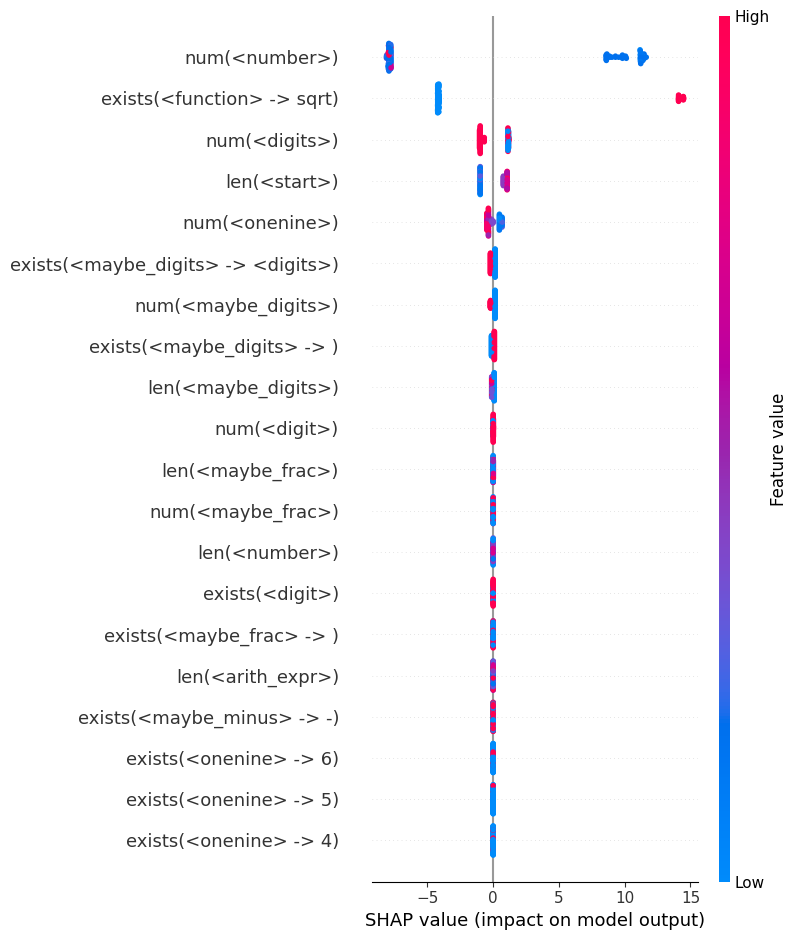

In [18]:
relevant_features, correlating_features, _ = feature_learner.learn(fuzzing_inputs)

In [19]:
relevant_features

{exists(<function> -> sqrt), num(<number>)}

In [20]:
correlating_features

{len(<function>)}